In [1]:
from importing import *
from TravelAndMutate.randominterface import NumpyRandomGenerator
from TravelAndMutate.system import System

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb
from time import time
from scipy.optimize import root_scalar

In [3]:
seed = np.prod([ord(c) for c in "TravelAndMutate"]).astype("uint32")
rng = NumpyRandomGenerator(seed)

In [4]:
def kernel(rng, tmax, params, commuting_mat):
    sys = System(rng.cpprng, 1, commuting_mat, params.to_records(index=False))
    sys.spreadForTime(tmax)
    return [pd.DataFrame.from_records(sys.getFullTrajectory(p), index="t") / params["N"][p] for p in range(params.shape[0])]

In [5]:
start = time()

Npatch = 2
tmax = 100000
reps = 30
commuting = np.diag(np.full(Npatch, 1))
betas = np.linspace(0.4,0.6,2)
epsilons = np.linspace(0.1,0.5,2)
mus = np.linspace(0.2,0.3,2)

results = []

for j,beta in enumerate(betas):
	for k,epsilon in enumerate(epsilons):
		for l,mu in enumerate(mus):
			for i in range(reps):
			
				params = pd.DataFrame()
				params["N"] = np.full(Npatch, 1e5, dtype="u4")
				params["beta"] = np.full(Npatch, beta)
				params["epsilon"] = np.full(Npatch, epsilon)
				params["mu"] = np.full(Npatch, mu)
				params["I0"] = np.zeros(Npatch, dtype="u4")
				params.loc[0, "I0"] = 2
				params.index.name = "Patch"
	
				result = kernel(rng, tmax, params, commuting)
				df = result[0]["I"].reset_index()
				df["t"] = df["t"].astype(int) - df["t"].iloc[result[0]["I"].argmax()]
				df["beta"] = beta
				df["epsilon"] = epsilon
				df["mu"] = mu
				results.append(df)
				print(f"{(((j*len(epsilons)+k)*len(mus)+l)*reps+i)*100//(len(betas)*len(epsilons)*len(mus)*reps)}%", flush=True, end="\r")

results = pd.concat(results)

end = time()
print(f"Time elapsed: {end-start} sec")

Time elapsed: 1.5406920909881592 sec


In [6]:
#results["t"] = results["t"] - results["t"].min()
results["epsilon"] = pd.Categorical(results["epsilon"])
results["mu"] = pd.Categorical(results["mu"])

The equation is

$$
\begin{pmatrix}
\dot{S} \\
\dot{E} \\
\dot{I} \\
\dot{R}
\end{pmatrix}
=
\begin{pmatrix}
-\beta S I \\
+\beta S I - \varepsilon E \\
+\varepsilon E - \mu I \\
+\mu I
\end{pmatrix}
$$

The Jacobian $J_{ij} = \partial_j f_i$ is

$$
J = 
\begin{pmatrix}
-\beta I & 0 & -\beta S & 0 \\
+\beta I & -\varepsilon & +\beta S & 0 \\
0 & +\varepsilon & -\mu & 0 \\
0 & 0 & +\mu & 0
\end{pmatrix}
$$

which evaluated in the initial state $S = 1$ and $I = 0$ becomes

$$
J = 
\begin{pmatrix}
0 & 0 & -\beta & 0 \\
0 & -\varepsilon & +\beta & 0 \\
0 & +\varepsilon & -\mu & 0 \\
0 & 0 & +\mu & 0
\end{pmatrix}
$$

which has eigenvalues $\lambda_1 = 0$, $\lambda_2 = 0$, $\lambda_{3,4} = \frac{1}{2}\left( \pm \sqrt{\varepsilon^2 + 4\beta\varepsilon - 2\varepsilon\mu + \mu^2} - \left(\varepsilon+\mu\right) \right)$

$$
\frac{1}{2}\left( \pm \sqrt{4\beta\varepsilon - 4\varepsilon\mu + \left(\varepsilon+\mu\right)^2} - \left(\varepsilon+\mu\right) \right)
$$

$$
\frac{1}{2}\left( \pm \sqrt{4\left(\beta - \mu\right)\varepsilon + \left(\varepsilon+\mu\right)^2} - \left(\varepsilon+\mu\right) \right)
$$

$$
\frac{1}{2}\left( \pm \sqrt{4\left(R_0 - 1\right)\varepsilon\mu + \left(\varepsilon+\mu\right)^2} - \left(\varepsilon+\mu\right) \right)
$$

In [7]:
def f(t, t0, beta, epsilon, mu, I0):
	exponent = np.sqrt(4*(beta/mu-1)*epsilon*mu + (epsilon+mu)**2) - (epsilon+mu)
	return I0 * np.exp(1/2 * exponent * (t-t0))

In [8]:
from matplotlib.colors import Normalize

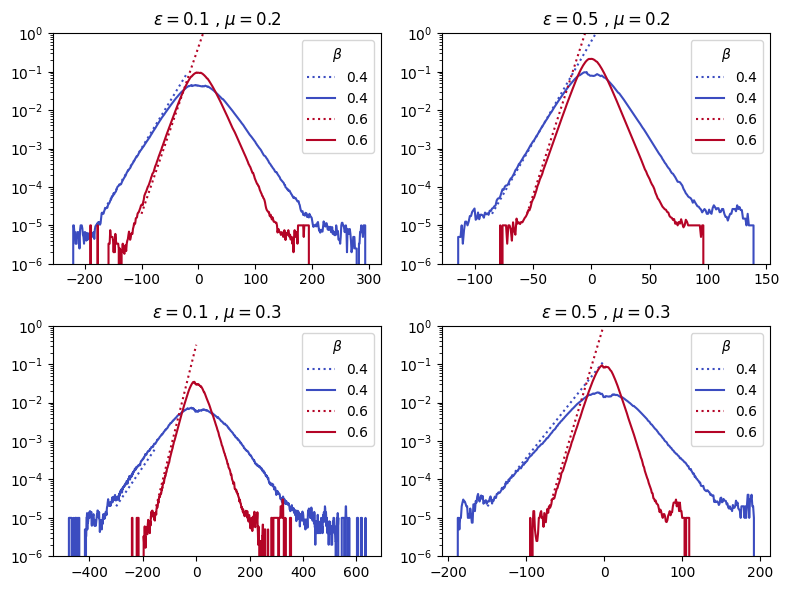

In [9]:
#plot = sb.relplot(data=results, x="t", y="I", hue="beta", col="epsilon", row="mu", kind="line", palette="coolwarm")
fig, axs = plt.subplots(2,2,figsize=(8,6))
axs = axs.flatten()
mycolors = plt.cm.coolwarm(Normalize(min(betas),max(betas))(betas))
#axs = plot.axes.flatten()
t0s = [[170,100],[85,55],[300,150],[150,70]]
for i,ax in enumerate(axs):
	for j,beta in enumerate(betas):
		mask = np.logical_and(results["mu"]==mus[i//len(epsilons)], results["epsilon"]==epsilons[i%len(epsilons)])
		filtered = results.loc[mask]
		filtered = filtered.loc[filtered["beta"]==beta]
		filtered = filtered[["t","I"]].groupby("t").mean()
		ts = np.linspace(0,150,101)
		ax.plot(ts-t0s[i][j], f(ts, 0, beta, epsilons[i%len(epsilons)], mus[i//len(epsilons)], 2/1e5), ls=":", color=mycolors[j], label=str(beta))
		ax.plot(filtered, color=mycolors[j], label=str(beta))
	ax.set_title(r"$\varepsilon = $"+str(epsilons[i%len(epsilons)])+r" , $\mu = $"+str(mus[i//len(epsilons)]))
	ax.set_yscale("log")
	ax.set_ylim([1e-6,1])
	#ax.set_xlim([-130,200])
	ax.legend(title=r"$\beta$")
fig.tight_layout()
fig.savefig("../plots/initial_growth.png")